# 程式 3.1: 建立一個Gridworld遊戲

In [40]:
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

# 程式 3.8： 利用經驗回放和目標網路訓練DQN

# 改爲用 pytorch + call back

In [78]:
pip install pytorch-lightning==1.6.0

In [77]:
import pytorch_lightning as pl
print(pl.__version__)

1.6.0


## ⬇️ 改寫 3.8 的 code(1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch [100/5000], Loss: 1.3333
Epoch [200/5000], Loss: 1.4336
Epoch [300/5000], Loss: 1.3677
Epoch [400/5000], Loss: 1.3658
Epoch [500/5000], Loss: 1.3366
Epoch [600/5000], Loss: 1.4872
Epoch [700/5000], Loss: 1.4255
Epoch [800/5000], Loss: 1.3011
Epoch [900/5000], Loss: 1.4927
Epoch [1000/5000], Loss: 1.3140
Epoch [1100/5000], Loss: 1.4641
Epoch [1200/5000], Loss: 1.4093
Epoch [1300/5000], Loss: 1.4013
Epoch [1400/5000], Loss: 1.5172
Epoch [1500/5000], Loss: 1.4511
Epoch [1600/5000], Loss: 1.3732
Epoch [1700/5000], Loss: 1.2774
Epoch [1800/5000], Loss: 1.3671
Epoch [1900/5000], Loss: 1.3994
Epoch [2000/5000], Loss: 1.4516
Epoch [2100/5000], Loss: 1.4080
Epoch [2200/5000], Loss: 1.3595
Epoch [2300/5000], Loss: 1.3645
Epoch [2400/5000], Loss: 1.2793
Epoch [2500/5000], Loss: 1.4658
Epoch [2600/5000], Loss: 1.4232
Epoch [2700/5000], Loss: 1.5165
Epoch [2800/5000], Loss: 1.2694
Epoch [2900/5000], Loss: 1.4444
Epoch [3000/5000], Loss: 1.3894
Epoch [3100/5000], Loss: 1.4315
Epoch [3200/5000]

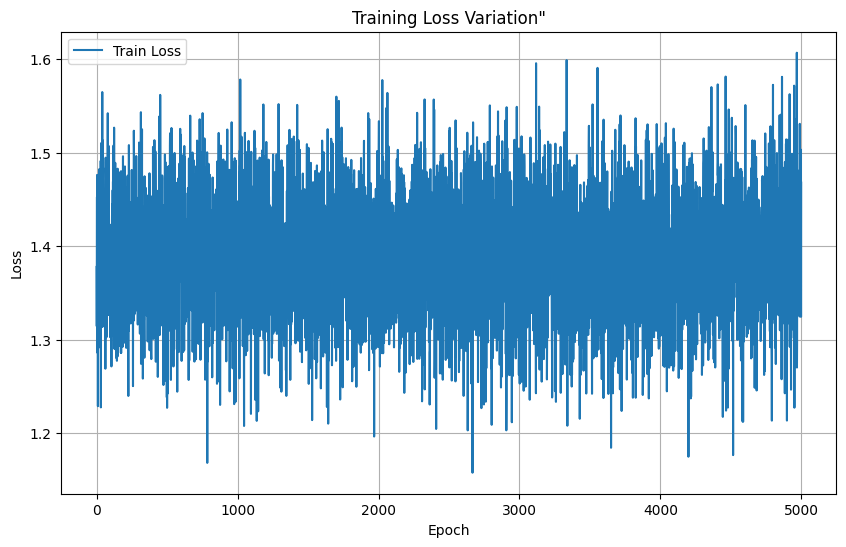

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch
import torch.nn as nn
import torch.nn.functional as F

# 假設動作集合已定義
action_set = ['上', '下', '左', '右']

# 定義 Q 網路架構
class QNet(pl.LightningModule):
    def __init__(self, input_dim=64, output_dim=4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # 第一層全連接層
        self.fc2 = nn.Linear(128, 64)         # 第二層全連接層
        self.fc3 = nn.Linear(64, output_dim)  # 輸出層

    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU 激活函數
        x = F.relu(self.fc2(x))  # ReLU 激活函數
        return self.fc3(x)       # 返回最終輸出

    def training_step(self, batch, batch_idx):
        # 定義訓練步驟，這裡可以根據需要修改
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)  # 記錄訓練損失
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

# 初始化 LightningModule 和 Trainer
gridworld_model = QNet()
early_stopping = EarlyStopping(monitor='train_loss', patience=5, mode='min')
gridworld_trainer = pl.Trainer(max_epochs=5000, gpus=1, callbacks=[early_stopping])

# 虛擬的訓練循環來生成損失
losses = []
for epoch in range(1, 5001):
    # 模擬生成符合模型要求的隨機輸入和標籤
    x = torch.randn(1, 64)  # 假設輸入維度為 (1, 64)
    y = torch.randint(0, 4, (1,))  # 假設標籤維度為 (1,)

    # 使用 trainer 的 training_step 方法進行訓練步驟
    output = gridworld_model.training_step((x, y), epoch)

    # 檢查早停條件
    if gridworld_trainer.should_stop:
        print("Early stopping criteria met")
        break

    # 模擬印出準確率等資訊
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/5000], Loss: {output:.4f}")

    # 將損失記錄下來
    losses.append(output.item())

# 繪製訓練損失曲線
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Variation"')
plt.legend()
plt.grid(True)
plt.show()


## ⬇️ 改寫 3.8 的 code(2)

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

# Gridworld imports
from Gridworld import Gridworld
from GridBoard import GridBoard

# 定義 Q 網路模型
class QNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # 第一層全連接層
        self.fc2 = nn.Linear(128, 64)         # 第二層全連接層
        self.fc3 = nn.Linear(64, output_dim)  # 輸出層

    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU 激活函數
        x = F.relu(self.fc2(x))  # ReLU 激活函數
        return self.fc3(x)       # 返回最終輸出

# 定義 LightningModule 來實現 Q 學習
class LightningGridworld(pl.LightningModule):
    def __init__(self, size=4, mem_size=1000, batch_size=200, sync_freq=500, gamma=0.9, max_moves=50, epsilon_decay=1/5000):
        super(LightningGridworld, self).__init__()
        self.size = size
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.sync_freq = sync_freq
        self.gamma = gamma
        self.max_moves = max_moves
        self.epsilon_decay = epsilon_decay

        # 定義模型
        self.model = QNet(64, 4)
        self.model2 = QNet(64, 4).eval()  # 目標網路

        # 定義優化器和損失函數
        self.optimizer = optim.Adam(self.model.parameters())
        self.loss_fn = nn.MSELoss()

        # 初始化回放記憶
        self.replay = deque(maxlen=self.mem_size)

        # 其他變數
        self.epsilon = 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        state1_batch, action_batch, reward_batch, state2_batch, done_batch = batch

        Q1 = self.model(state1_batch)
        with torch.no_grad():
            Q2 = self.model2(state2_batch)

        Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
        X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
        loss = self.loss_fn(X, Y.detach())

        self.log('train_loss', loss)  # 使用 self.log 記錄訓練損失

        return loss

    def configure_optimizers(self):
        return self.optimizer

    def train_dataloader(self):
        # 假設回放記憶已經以張量形式存儲
        if len(self.replay) > 0:
            replay_data = list(self.replay)
            state1_list, action_list, reward_list, state2_list, done_list = zip(*replay_data)

            state1_tensor = torch.cat(state1_list)
            action_tensor = torch.Tensor(action_list)
            reward_tensor = torch.Tensor(reward_list)
            state2_tensor = torch.cat(state2_list)
            done_tensor = torch.Tensor(done_list)

            dataset = TensorDataset(state1_tensor, action_tensor, reward_tensor, state2_tensor, done_tensor)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

            return dataloader
        else:
            # 如果回放記憶為空，返回一個空的 DataLoader，或者根據需要處理這種情況
            return DataLoader([])  # 根據需要替換為適當的處理邏輯

    def experience_replay_step(self):
        # 如果需要，可以在這裡實現回放記憶的邏輯
        if len(self.replay) > self.batch_size:
            minibatch = random.sample(self.replay, self.batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])

            batch = (state1_batch, action_batch, reward_batch, state2_batch, done_batch)
            return batch
        else:
            return None

    def experience_replay(self):
        self.experience_replay_step()

    def epsilon_decay_step(self, epoch):
        self.epsilon = max(0.1, 1.0 - epoch * self.epsilon_decay)

    def training_epoch_end(self, outputs):
        self.epsilon_decay_step(self.current_epoch)

    def training_epoch_step(self, epoch, batch_idx, optimizer_idx=None):
        game = Gridworld(size=self.size, mode='random')
        state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        state1 = torch.from_numpy(state1_).float()

        status = 1
        mov = 0
        while status == 1:
            mov += 1
            qval = self.model(state1)
            qval_ = qval.data.numpy()

            if random.random() < self.epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)

            action = action_set[action_]
            game.makeMove(action)
            state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            state2 = torch.from_numpy(state2_).float()
            reward = game.reward()
            done = True if reward != -1 else False
            exp = (state1, action_, reward, state2, done)
            self.replay.append(exp)
            state1 = state2

            if reward != -1 or mov > self.max_moves:
                status = 0
                mov = 0

            self.experience_replay()

    def validation_step(self, batch, batch_idx):
        state1_batch, action_batch, reward_batch, state2_batch, done_batch = batch

        Q1 = self.model(state1_batch)
        with torch.no_grad():
            Q2 = self.model2(state2_batch)

        Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
        X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
        loss = self.loss_fn(X, Y.detach())

        self.log('val_loss', loss)  # 使用 self.log 記錄驗證損失

    def validation_epoch_end(self, outputs):
        val_loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        self.log('avg_val_loss', val_loss_mean)  # 記錄平均驗證損失
        return {'avg_val_loss': val_loss_mean}

# 假設動作集合已經在其他地方定義
action_set = ['上', '下', '左', '右']

# 初始化 LightningGridworld 和 Trainer
gridworld_model = LightningGridworld()
early_stop_callback = pl.callbacks.EarlyStopping(monitor='avg_val_loss', patience=5, verbose=True, mode='min')  # 定義 early stop 機制
gridworld_trainer = pl.Trainer(max_epochs=5000, gpus=1, callbacks=[early_stop_callback])  # 如果有GPU則啟用GPU訓練

# 訓練模型
gridworld_trainer.fit(gridworld_model)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | model   | QNet    | 16.8 K
1 | model2  | QNet    | 16.8 K
2 | loss_fn | MSELoss | 0     
------------------------------------
33.7 K    Trainable params
0         Non-trainable params
33.7

Training: 0it [00:00, ?it/s]

## 測試勝率

In [70]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random')
    if win:
      wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

串流輸出內容已截斷至最後 5000 行。
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Move #: 9; Taking action: right
[['P' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Move #: 10; Taking action: right
[['P' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Move #: 11; Taking action: right
[['P' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Move #: 12; Taking action: right
[['P' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Move #: 13; Taking action: right
[['P' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Move #: 14; Taking action: right
[['P' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Move #: 15; Taking action: right
[['P' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Game lost; too many moves.
False
Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']
 ['-' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: right
[[' ' ' ' ' ' 